In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch

torch.cuda.set_device(5)
torch.cuda.current_device()

import warnings
from pathlib import Path
from wrappers.transformer_wrapper import FairseqTransformerHub

import alignment.align as align

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import logging
logger = logging.getLogger()

logger.setLevel('WARNING')
warnings.simplefilter('ignore')

from dotenv import load_dotenv
load_dotenv()
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load model

In [3]:
data_sample = 'interactive' # generate/interactive
teacher_forcing = True # teacher forcing/free decoding

green_color = '#82B366'
red_color = '#B85450'

In [4]:
# Paths
europarl_dir = Path(os.environ['EUROPARL_DATA_DIR'])
ckpt_dir = Path(os.environ['EUROPARL_CKPT_DIR'])
iwslt14_dir = Path(os.environ['IWSLT14_DATA_DIR'])
gold_dir = Path(os.environ['GOLD_ALIGNMENT_DATA_DIR'])
#ckpt_dir = Path(os.environ['IWSLT14_CKPT_DIR'])

# Choose model
model_type = 'baseline'
seed = 5498 # 2253  2453  5498  9240	9819

hub = FairseqTransformerHub.from_pretrained(
    ckpt_dir / f"{model_type}/{seed}",
    checkpoint_file=f"checkpoint_best.pt",
    data_name_or_path=(europarl_dir / "processed_data/fairseq_preprocessed_data").as_posix(), # processed data
    #(data_name_or_path=iwslt14_dir / "data-bin").as_posix(), 
)
NUM_LAYERS = 6


## Get sample for analysis

In [5]:
# Get sample from provided test data

if data_sample == 'generate':
    i = 368  # 0, 1 28, 45, 148 (pred_tok vs tgt_tok), 178, 16 (Hallucination), 421 (Hallucination)

    src_sent, src_tok, src_tensor, tgt_sent, tgt_tok, tgt_tensor = hub.get_sample('test', i)
    print(f"\nSource sentence: \t {src_sent}")
    print(f"Target sentence: \t {tgt_sent}")

In [44]:
test_set_dir = europarl_dir / "processed_data/"
src = "de"
tgt = "en"
tokenizer = "bpe"

for i in range(508):
    # index in dataset
    sample = hub.get_interactive_sample(i, test_set_dir, src, tgt, tokenizer, hallucination=None)
    if sample['src_tensor'].size(0) < 10 and sample['src_tensor'].size(0) > 14:
        print(i)
        print(sample['src_word_sent'])
        print(sample['tgt_word_sent'])

In [5]:
if data_sample == 'interactive':
    # Get sample from Gold alignment dataset

    # index in dataset
    i = 120 # index in dataset
    # 3, 100, 105, 107, 120 (example paper), 163 (error visible)
    #test_set_dir = europarl_dir / "processed_data/"

    #test_set_dir = iwslt14_dir / "tokenized/"
    test_set_dir = gold_dir / "tokenized/"
    src = "de"
    tgt = "en"
    tokenizer = "bpe"
    sample = hub.get_interactive_sample(i, test_set_dir, src,
                                        tgt, tokenizer, hallucination=None)
    src_tensor = sample['src_tensor']
    tgt_tensor = sample['tgt_tensor']
    src_tok = sample['src_tok']

    print(sample['src_word_sent'])
    print(sample['tgt_word_sent'])

damit ist unsere aussprache über den stand der europäischen union geschlossen .

the debate on the state of the european union is closed .



### Teacher Forcing

In [6]:
if teacher_forcing:
    model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor, tgt_tensor)

    print("\n\nGREEDY DECODING\n")
    pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)
    pred_tok = hub.decode(pred_tensor, hub.task.tgt_dict)
    pred_sent = hub.decode(pred_tensor, hub.task.tgt_dict, as_string=True)
    print(f"Predicted sentence: \t {pred_sent}")

    source_sentence = src_tok
    target_sentence = sample['tgt_tok']
    predicted_sentence = pred_tok





GREEDY DECODING

Predicted sentence: 	 that debate on the state of the european union is closed .


In [7]:
# prefix_tokens = ['▁mr']
# eos_id = hub.task.tgt_dict.eos_index # EOS token index
# prefix_tokens = torch.tensor([eos_id] + [hub.tgt_dict.index(t) for t in prefix_tokens])
# prefix_tokens

In [8]:
if not teacher_forcing:
    tgt_tensor_free = []
    # prefix_tokens = ['</s>','</s>','</s>']
    # eos_id = hub.task.tgt_dict.eos_index # EOS token index
    # prefix_tokens = torch.tensor([eos_id] + [hub.tgt_dict.index(t) for t in prefix_tokens])

    prefix_tokens = torch.tensor([[3]]).to('cuda')
    inference_step_args={'prefix_tokens': prefix_tokens}
    inference_step_args = None

    print("\n\nBEAM SEARCH\n")
    for pred in hub.generate(src_tensor, 1, inference_step_args = inference_step_args):
        tgt_tensor_free.append(pred['tokens'])
        pred_sent = hub.decode(pred['tokens'], hub.task.tgt_dict, as_string=True)
        score = pred['score'].item()
        print(f"{score} \t {pred_sent}")

    hypo = 0 # first hypothesis
    tgt_tensor = tgt_tensor_free[hypo]
    
    # We add eos token at the beginning of sentence and delete it from the end
    tgt_tensor = torch.cat([torch.tensor([hub.task.tgt_dict.eos_index]).to(tgt_tensor.device),
                    tgt_tensor[:-1]
                ]).to(tgt_tensor.device)
    tgt_tok = hub.decode(tgt_tensor, hub.task.tgt_dict, as_string=False)
    target_sentence = tgt_tok
    source_sentence = src_tok

    model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor, tgt_tensor)

    print(f"\n\nGREEDY DECODING with hypothesis {hypo+1}\n")
    pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)
    pred_tok = hub.decode(pred_tensor, hub.task.tgt_dict)
    pred_sent = hub.decode(pred_tensor, hub.task.tgt_dict, as_string=True)
    print(f"Predicted sentence: \t {pred_sent}")
    predicted_sentence = pred_tok

In [9]:
tgt_tensor

tensor([   2,  119,  609,   64,    8,  550,   27,    8,  128,  248,   54, 2148,
          24])

In [10]:
probs = torch.nn.functional.softmax(log_probs, dim=-1)
print('probs',probs.size())
pred_ind = torch.argmax(probs,dim=-1)
print(pred_ind.size())
pred = torch.max(probs,dim=-1)
pred


probs torch.Size([13, 10001])
torch.Size([13])


torch.return_types.max(
values=tensor([0.7155, 0.4967, 0.7094, 0.8452, 0.7540, 0.9014, 0.8613, 0.8553, 0.8980,
        0.8889, 0.7860, 0.8912, 0.9014], device='cuda:5'),
indices=tensor([ 645,  609,   64,    8,  550,   27,    8,  128,  248,   54, 2148,   24,
           2], device='cuda:5'))

## Layer-wise Analysis

### Cross-attention

The output of the encoder is considered as input.
We add the residual connection contribution as DEC (blue residual in Figure).

![enc_dec](./img/cross_diagram.png)

## Attention weights cross-attention

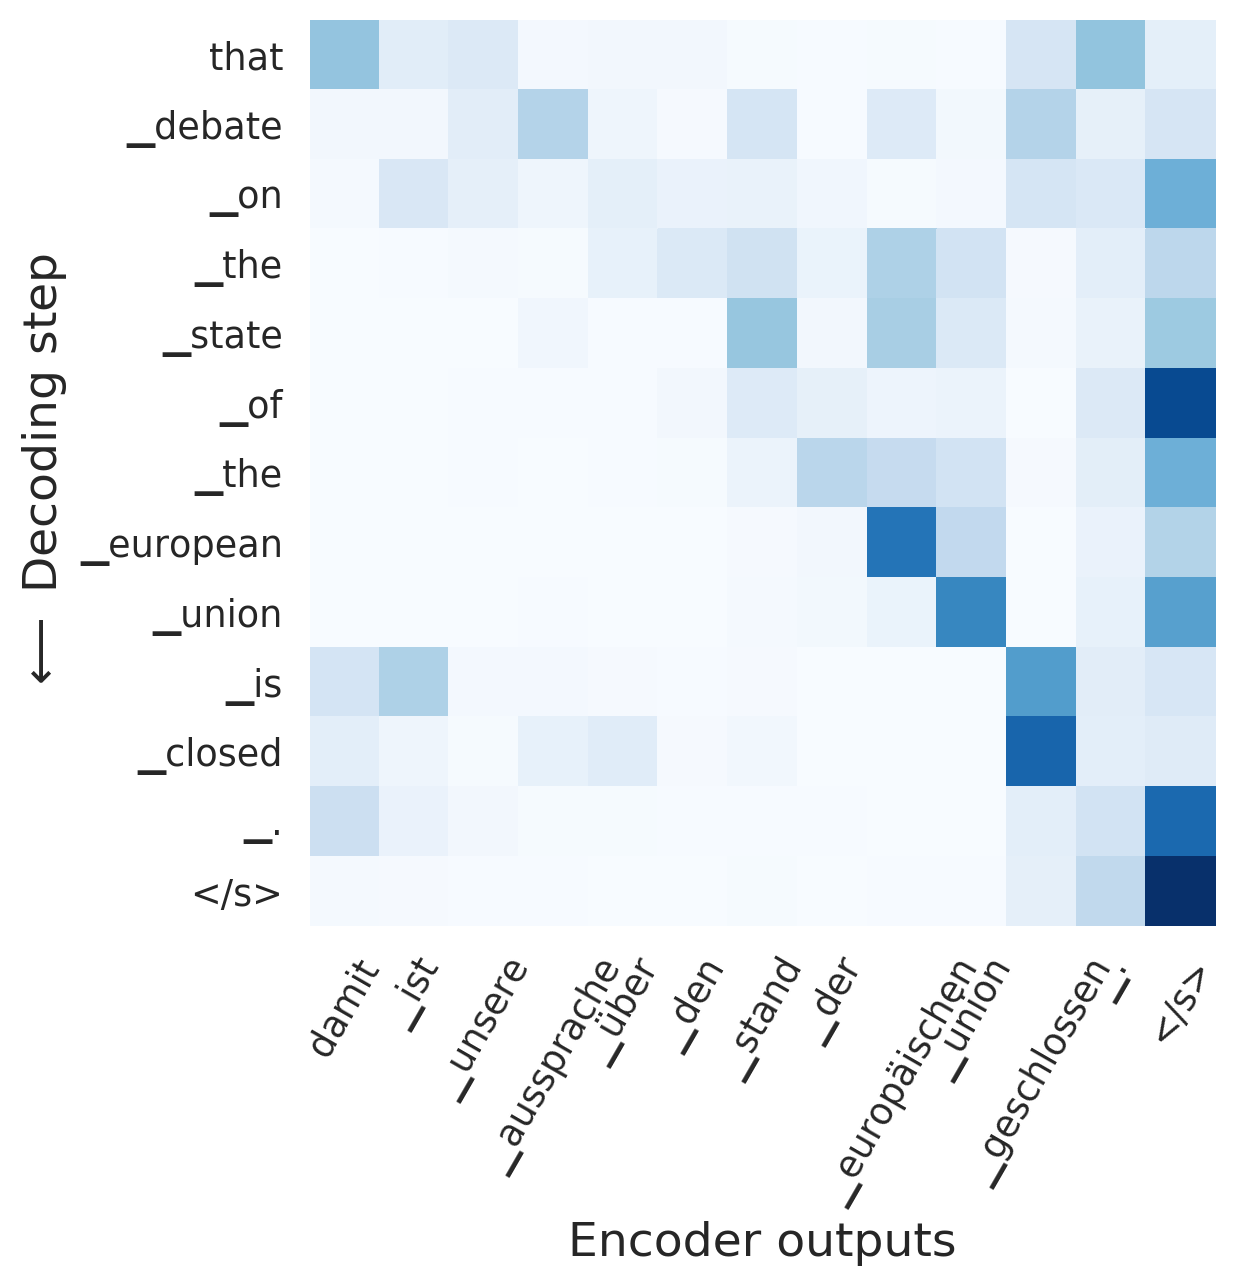

In [23]:

layer = 4

cross_attn_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'attn_w', norm_mode='sum_one')['decoder.encoder_attn'])

#cross_attn_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.encoder_attn'])
cross_attn_contributions = cross_attn_contributions.detach().cpu().numpy()
plt.figure(figsize=(6,6),dpi=200)

df = pd.DataFrame(cross_attn_contributions[layer],columns=source_sentence + ['</s>'],index=predicted_sentence + ['</s>'])
sns.set(font_scale=1.2)
#sns.heatmap(df,xticklabels = ['']*(len(src_tok)+1) + ['Residual'], cmap="Blues",square=True,cbar=False)
s = sns.heatmap(df, cmap="Blues",square=True,cbar=False)
s.set_xlabel('Encoder outputs', fontsize=17)
s.set_ylabel('$\longleftarrow$ Decoding step', fontsize=17)

plt.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=False);
plt.xticks(rotation=60);

mean residual 0.8117075 std 0.10419583


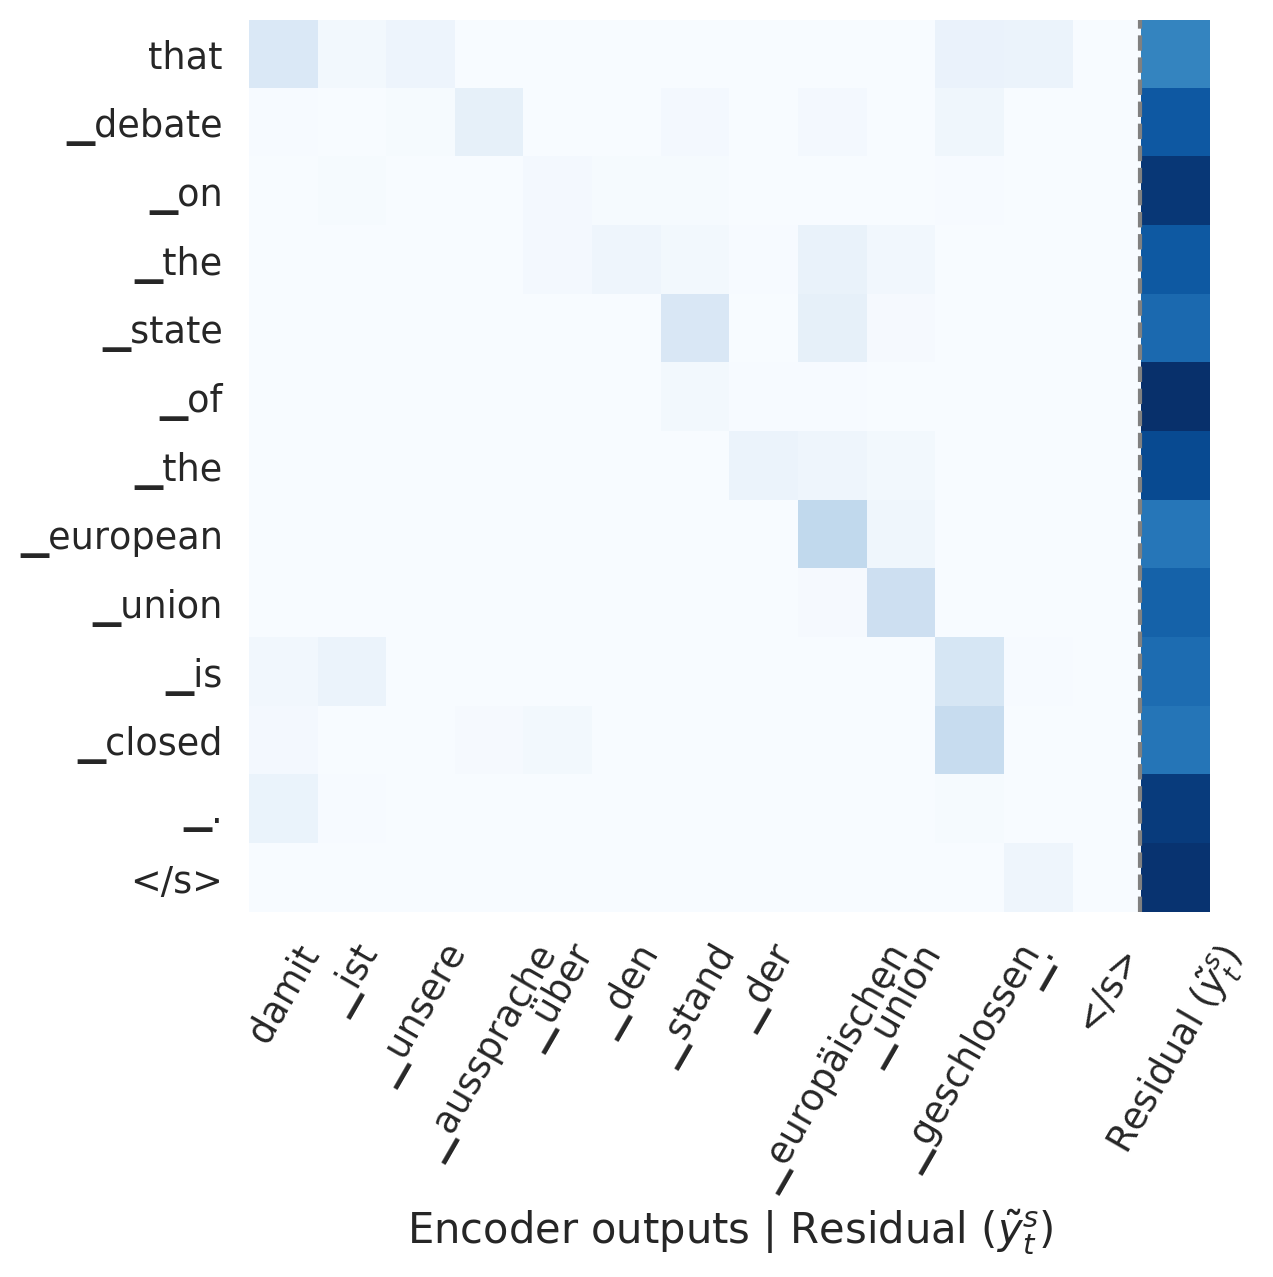

In [27]:
layer = 4

cross_attn_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.encoder_attn'])
cross_attn_contributions = cross_attn_contributions.detach().cpu().numpy()
plt.figure(figsize=(6.2,6.2),dpi=200)

df = pd.DataFrame(cross_attn_contributions[layer],columns=source_sentence + ['</s>'] + ['Residual'],index=predicted_sentence + ['</s>'])
sns.set(font_scale=1.2)
#sns.heatmap(df,xticklabels = ['']*(len(src_tok)+1) + ['Residual'], cmap="Blues",square=True,cbar=False)
s = sns.heatmap(df, cmap="Blues",square=True,cbar=False)
s.set_xlabel(r'Encoder outputs | Residual $(\tilde{y}^{s}_{t})$', fontsize=15)
#s.set_ylabel('Prediction at step (t)', fontsize=14)

plt.tick_params(axis='both', which='major', labelbottom = True, bottom=False, top = False, labeltop=False);
plt.xticks(ticks = plt.gca().get_xticks(), labels=source_sentence + ['</s>'] + [r'Residual $(\tilde{y}^{s}_{t})$'], rotation=60)
# for i, xtick in enumerate(plt.gca().get_xticklabels()):
#     plt.gca().get_xticklabels()[i].set_color(green_color)
#plt.gca().get_xticklabels()[-1].set_color(red_color)
plt.axvline(x = len(source_sentence)+0.98, lw=1.5, linestyle = '--', color = 'grey')# ymin = 0, ymax = 15

#plt.title('Contributions')

print('mean residual',df['Residual'].mean(), 'std', df['Residual'].std())


<Figure size 1200x1200 with 0 Axes>

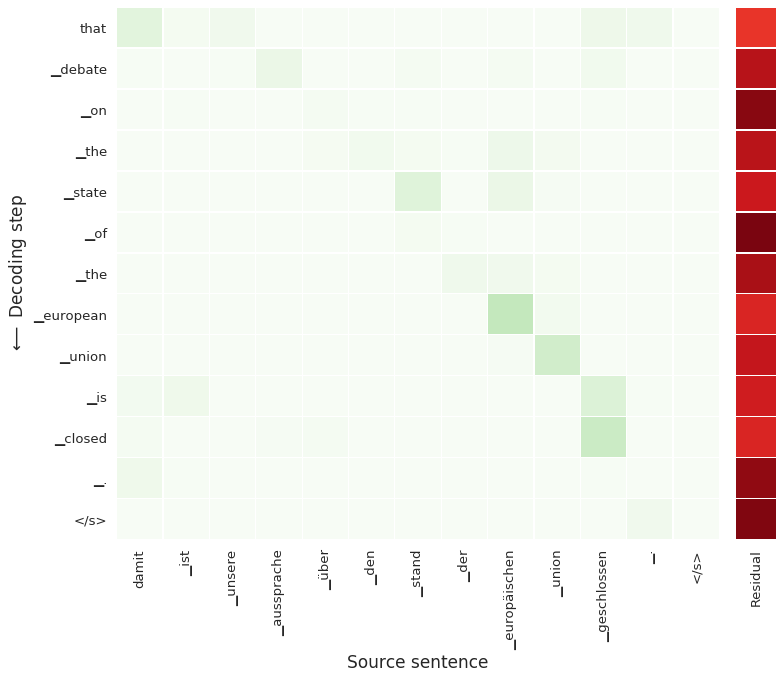

In [90]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# df = pd.read_csv(...)
# df.set_index('Date', inplace=True)
layer = 4

cross_attn_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.encoder_attn'])
cross_attn_contributions = cross_attn_contributions.detach().cpu().numpy()
plt.figure(figsize=(6,6),dpi=200)

df = pd.DataFrame(cross_attn_contributions[layer],columns=source_sentence + ['</s>'] + ['Residual'],index=predicted_sentence + ['</s>'])
column_labels = [col.replace(' ', '\n') for col in df.columns[:-1]]
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 10),
                               gridspec_kw={'width_ratios': [10, 1], 'wspace': 0.02, 'bottom': 0.14})
s = sns.heatmap(df.iloc[:,:-1], cmap='Greens', vmin=0, vmax=1,
            lw=0.2, cbar=False, ax=ax1, square=False)
sns.heatmap(df.iloc[:,-1].to_frame(), cmap='Reds', vmin=0, vmax=1,
            lw=0.2, yticklabels=[], cbar=False, ax=ax2, square=True)
s.set_xlabel('Source sentence', fontsize=17)
s.set_ylabel('$\longleftarrow$ Decoding step', fontsize=17)
ax2.set_ylabel('')
ax2.tick_params(axis='x', labelrotation=90)

plt.show()

In [15]:
# layer = 4

# cross_attn_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.encoder_attn'])
# cross_attn_contributions = cross_attn_contributions.detach().cpu().numpy()
# plt.figure(figsize=(5,5),dpi=200)

# df = pd.DataFrame(cross_attn_contributions[layer][:,:-1],columns=source_sentence + ['</s>'],index=predicted_sentence + ['</s>'])
# sns.set(font_scale=1.6)
# #sns.heatmap(df,xticklabels = ['']*(len(src_tok)+1) + ['Residual'], cmap="Blues",square=True,cbar=False)
# sns.heatmap(df, cmap="Blues",square=True,cbar=False)


# plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = True, bottom=False, top = False, labeltop=False);
# plt.xticks(rotation=60);


### Cross + self-attention per layer

We multiply the contributions of the decoder self-attention by the value of RES, and concatenate.

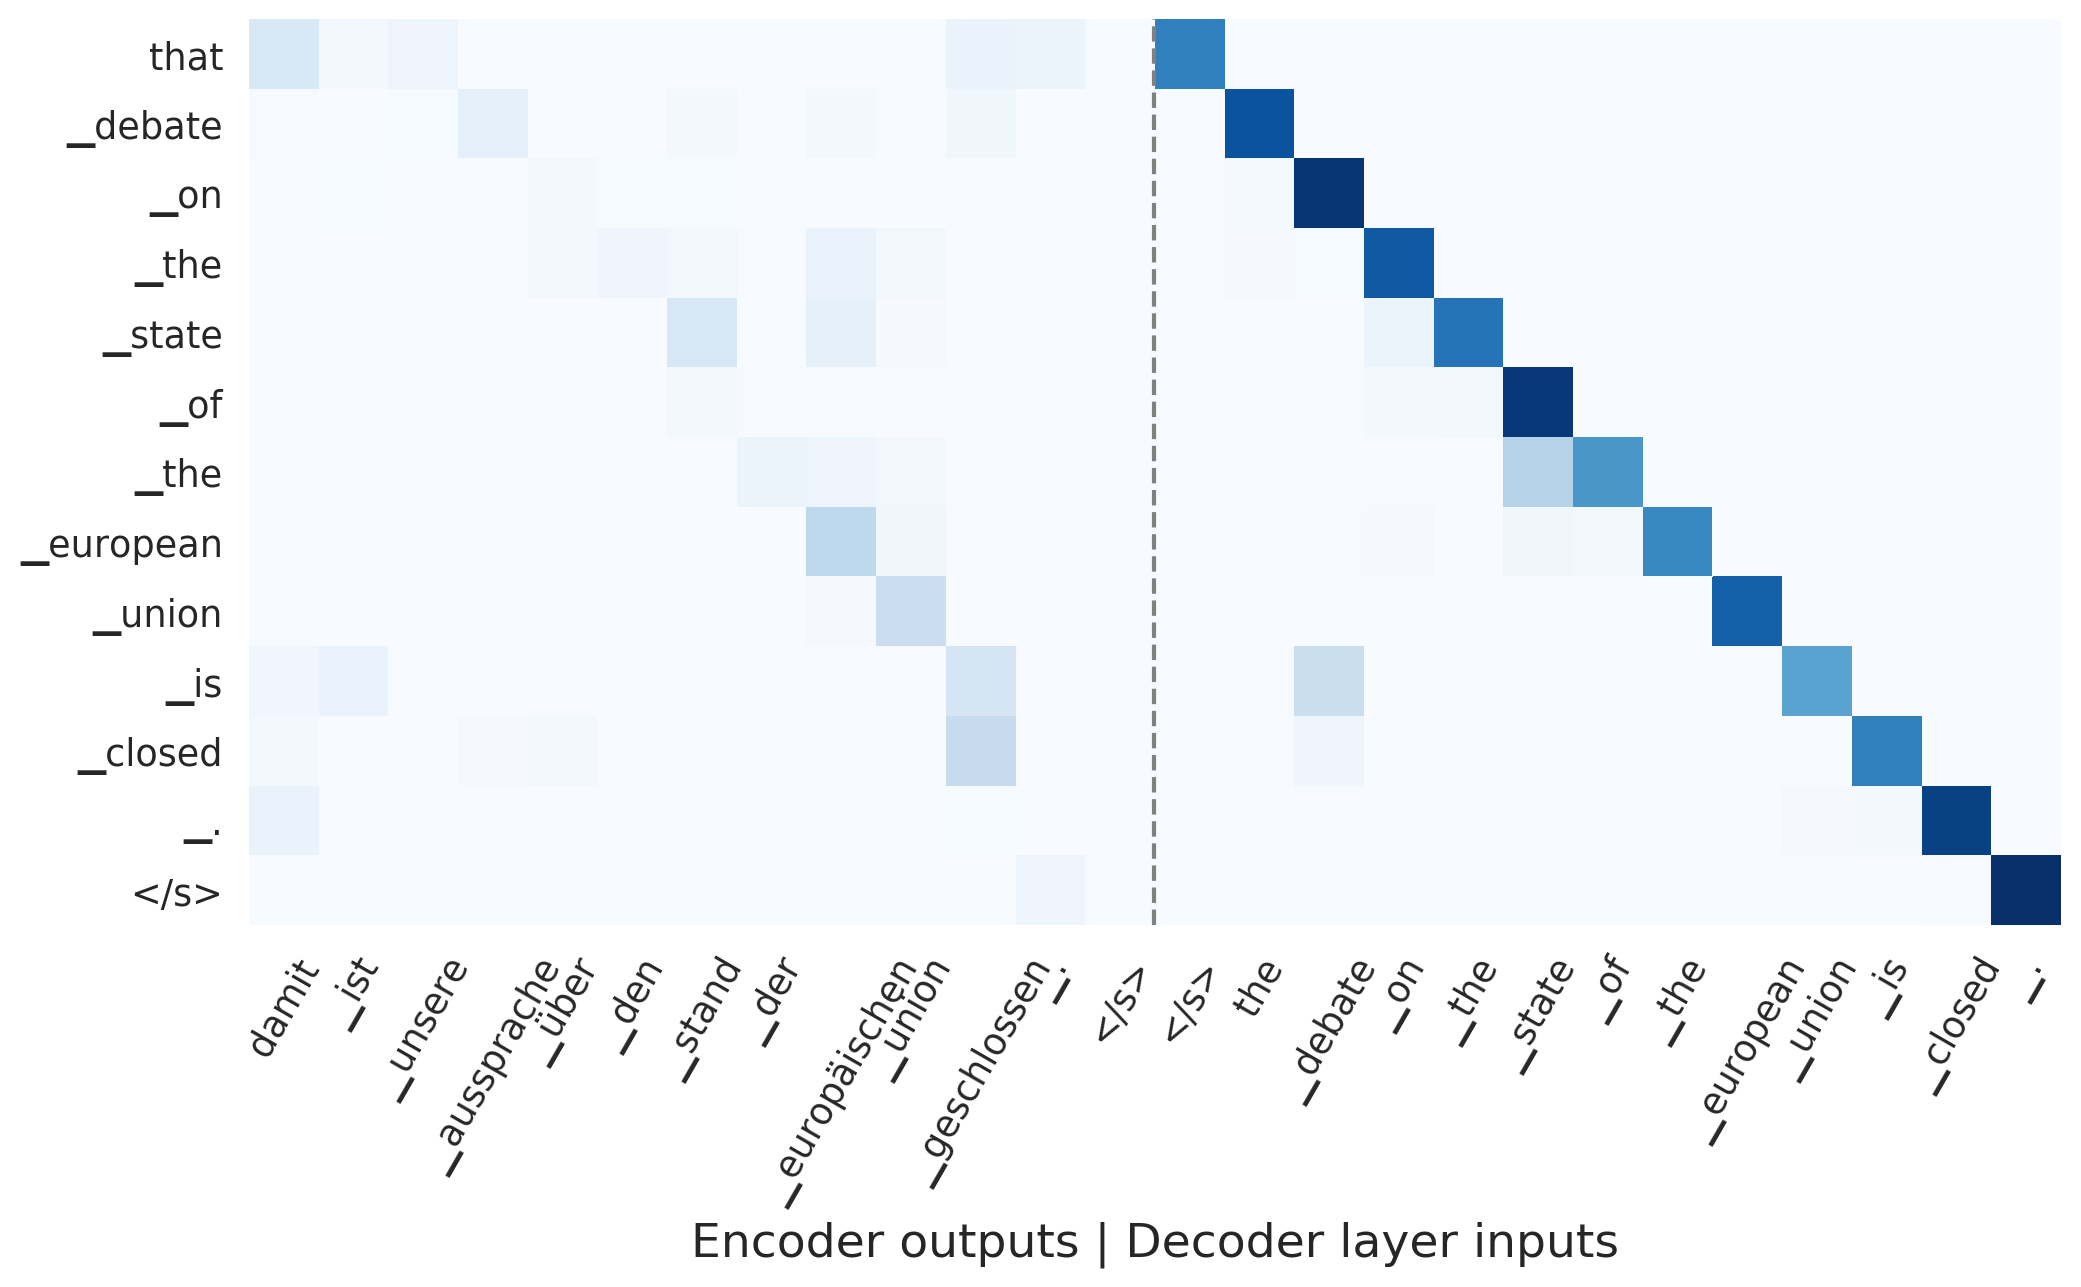

In [25]:
layer = 4
self_dec_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.self_attn'])#encoder.self_attn
cross_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.encoder_attn'])#encoder.self_attn
cross_contributions_layer = cross_contributions[layer]

self_dec_contributions_layer = (self_dec_contributions[layer].transpose(0,1)*cross_contributions_layer[:,-1]).transpose(0,1)
cross_contributions_layer = cross_contributions_layer[:,:-1]
final_cross_contributions = torch.cat((cross_contributions_layer,self_dec_contributions_layer),dim=1)
final_cross_contributions_np = final_cross_contributions.detach().cpu().numpy()
plt.figure(figsize=(15,6),dpi=200)
df = pd.DataFrame(final_cross_contributions_np, columns = source_sentence + ['</s>'] + ['</s>'] + target_sentence, index = predicted_sentence + ['</s>'])
sns.set(font_scale=1.2)
s = sns.heatmap(df,cmap="Blues",square=True, cbar=False)
s.set_xlabel('Encoder outputs | Decoder layer inputs', fontsize=17)
#s.set_ylabel('Prediction at step (t)', fontsize=16)
plt.xticks(rotation=60)
plt.axvline(x = len(source_sentence)+0.98, lw=1.5, linestyle = '--', color = 'grey')# ymin = 0, ymax = 15
src_len = len(source_sentence + ['</s>'])
tgt_len = len(predicted_sentence + ['</s>'])
# for i in range(src_len):
#     plt.gca().get_xticklabels()[i].set_color(green_color)
# for i in range(src_len,src_len + tgt_len):
#     plt.gca().get_xticklabels()[i].set_color(red_color)
#plt.gca().get_xticklabels()[-1].set_color(red_color);


<Figure size 3000x1200 with 0 Axes>

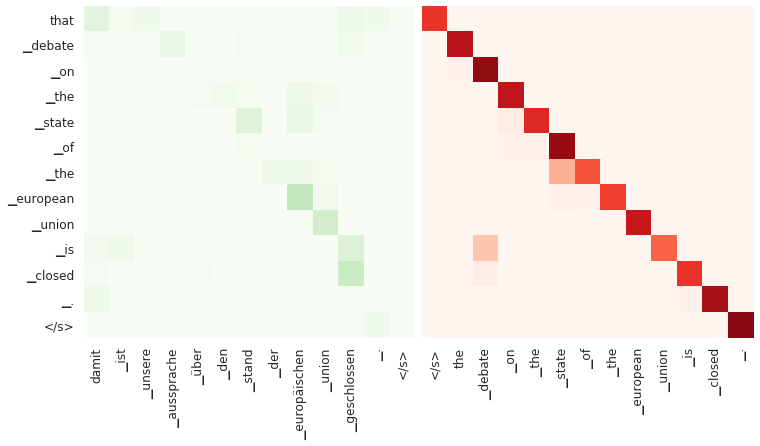

In [88]:
layer = 4
self_dec_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.self_attn'])#encoder.self_attn
cross_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.encoder_attn'])#encoder.self_attn
cross_contributions_layer = cross_contributions[layer]

self_dec_contributions_layer = (self_dec_contributions[layer].transpose(0,1)*cross_contributions_layer[:,-1]).transpose(0,1)
cross_contributions_layer = cross_contributions_layer[:,:-1]
final_cross_contributions = torch.cat((cross_contributions_layer,self_dec_contributions_layer),dim=1)
final_cross_contributions_np = final_cross_contributions.detach().cpu().numpy()
plt.figure(figsize=(15,6),dpi=200)
df = pd.DataFrame(final_cross_contributions_np, columns = source_sentence + ['</s>'] + ['</s>'] + target_sentence, index = predicted_sentence + ['</s>'])
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 10),
                               gridspec_kw={'width_ratios': [5, 5], 'wspace': 0.02, 'bottom': 0.14})
sns.heatmap(df.iloc[:,:len(source_sentence)+1], cmap='Greens', vmin=0, vmax=1,
            lw=0, cbar=False, ax=ax1, square=True)
sns.heatmap(df.iloc[:,len(source_sentence)+1:], cmap='Reds', vmin=0, vmax=1,
            lw=0, yticklabels=[], cbar=False, ax=ax2, square=True)


## ALTI analysis

### ALTI of the encoder

In [16]:
print(src_tensor.size())
print(tgt_tensor.size())

torch.Size([23])
torch.Size([28])


In [17]:
relevances_enc_self_attn = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['encoder.self_attn']

resultants_norm torch.Size([23])
contributions torch.Size([1, 23, 23])
encoder.self_attn
resultants_norm torch.Size([23])
contributions torch.Size([1, 23, 23])
encoder.self_attn
resultants_norm torch.Size([23])
contributions torch.Size([1, 23, 23])
encoder.self_attn
resultants_norm torch.Size([23])
contributions torch.Size([1, 23, 23])
encoder.self_attn
resultants_norm torch.Size([23])
contributions torch.Size([1, 23, 23])
encoder.self_attn
resultants_norm torch.Size([23])
contributions torch.Size([1, 23, 23])
encoder.self_attn
resultants_norm torch.Size([28])
contributions torch.Size([1, 28, 28])
decoder.self_attn
resultants_norm torch.Size([28])
contributions torch.Size([1, 28, 28])
decoder.self_attn
resultants_norm torch.Size([28])
contributions torch.Size([1, 28, 28])
decoder.self_attn
resultants_norm torch.Size([28])
contributions torch.Size([1, 28, 28])
decoder.self_attn
resultants_norm torch.Size([28])
contributions torch.Size([1, 28, 28])
decoder.self_attn
resultants_norm torch

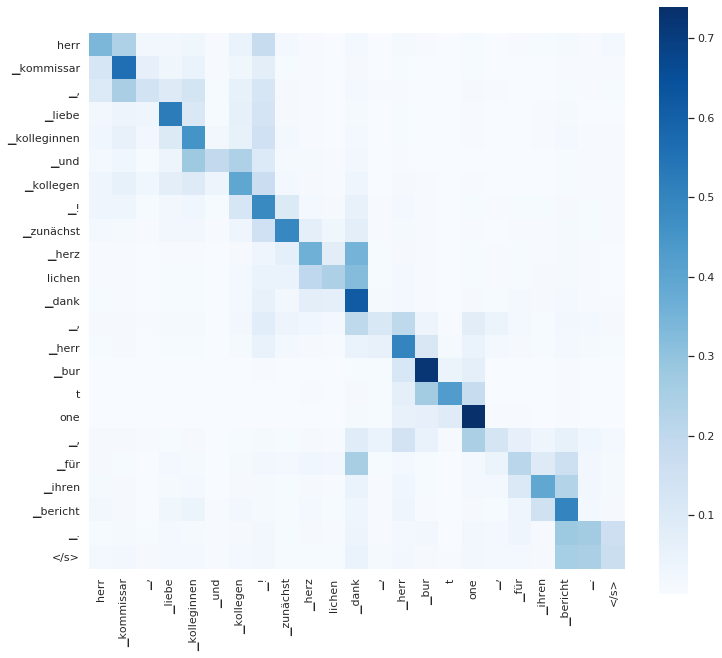

In [57]:
# Encoder self-attention relevances in last layer (full encoder ALTI)
plt.figure(figsize=(12,12))
df = pd.DataFrame(relevances_enc_self_attn[-1].cpu().detach().numpy(),columns= source_sentence + ['</s>'], index= source_sentence + ['</s>'])
sns.set(font_scale=1)
sns.heatmap(df,cmap="Blues",square=True)
plt.gcf().subplots_adjust(bottom=0.2)

In [55]:
torch.diagonal(relevances_enc_self_attn[-1]).mean()

tensor(0.3907, device='cuda:5')

In [58]:
relevances_enc_self_attn[-1].size()

torch.Size([23, 23])

In [52]:
relevances_enc_self_attn[-1]

tensor([[3.3893e-01, 2.3863e-01, 2.2090e-02, 2.2729e-02, 3.0523e-02, 3.2622e-03,
         4.9310e-02, 1.8135e-01, 1.7862e-02, 4.3717e-03, 2.3338e-03, 1.4825e-02,
         3.0542e-03, 1.2029e-02, 5.1653e-03, 1.1915e-03, 6.7120e-03, 2.9289e-03,
         3.5988e-03, 7.2178e-03, 1.2176e-02, 4.5676e-03, 1.5153e-02],
        [1.2099e-01, 5.5988e-01, 6.2605e-02, 3.0599e-02, 5.1653e-02, 4.2251e-03,
         2.9528e-02, 7.5364e-02, 8.3263e-03, 5.7194e-03, 2.2205e-03, 1.0398e-02,
         2.7927e-03, 6.6705e-03, 1.9689e-03, 8.4048e-04, 7.3027e-03, 2.5887e-03,
         2.4548e-03, 1.4043e-03, 4.9747e-03, 3.4654e-03, 4.0310e-03],
        [1.0323e-01, 2.5128e-01, 1.4089e-01, 9.5385e-02, 1.3411e-01, 8.1986e-03,
         6.0313e-02, 1.1965e-01, 1.1040e-02, 5.6866e-03, 2.3903e-03, 1.5416e-02,
         4.5239e-03, 6.0299e-03, 2.8923e-03, 6.2618e-04, 9.2216e-03, 4.3766e-03,
         1.9199e-03, 2.6199e-03, 7.7529e-03, 4.6531e-03, 7.7884e-03],
        [2.1550e-02, 4.0016e-02, 3.3218e-02, 5.2327e-01, 1.09

### Cross-attention on Encoder input (ALTI)

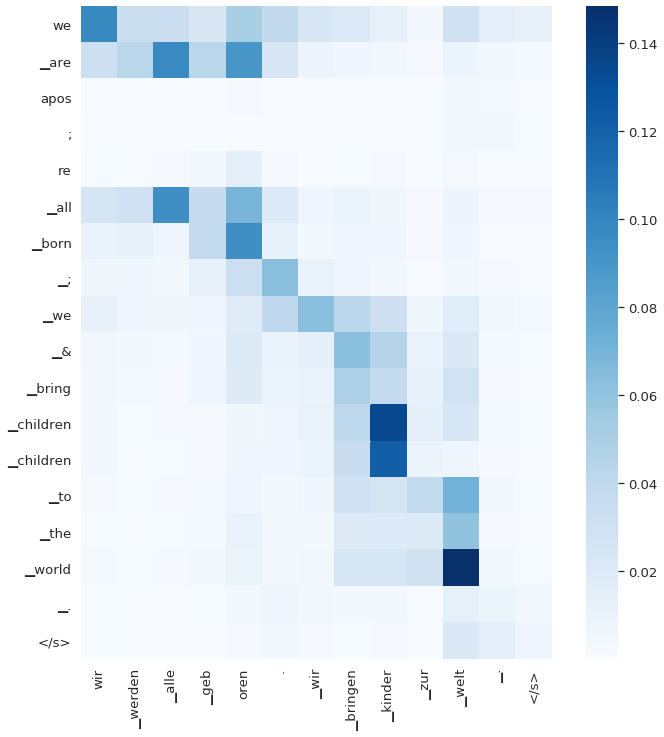

In [12]:
layer = 4

cross_attn_contributions = torch.squeeze(hub.get_contributions(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['decoder.encoder_attn'])
combined_alti_enc_cross = torch.matmul(cross_attn_contributions[layer][:,:-1],relevances_enc_self_attn[-1])
df = pd.DataFrame(combined_alti_enc_cross.detach().cpu().numpy(), columns=source_sentence + ['</s>'], index=predicted_sentence + ['</s>'])
sns.set(font_scale=1.2)
sns.heatmap(df,cmap="Blues",square=True)

### ALTI of the entire model

In [13]:
total_rollout = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['total']

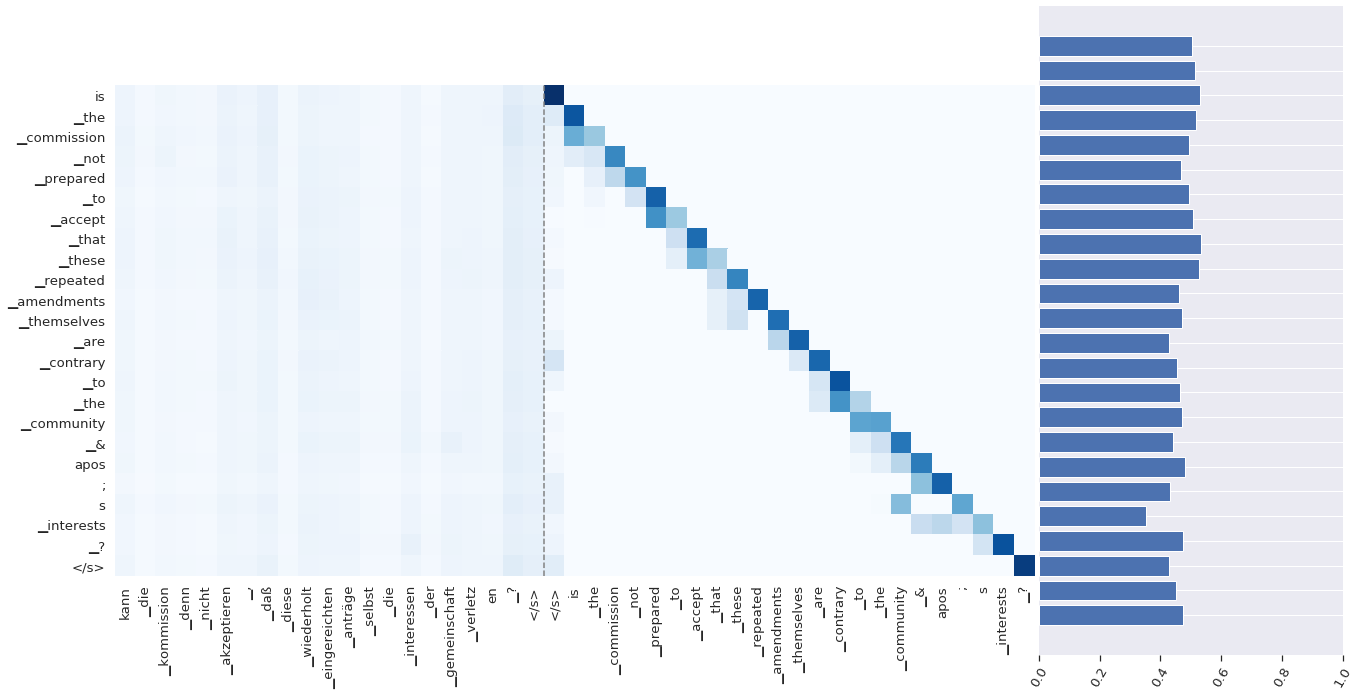

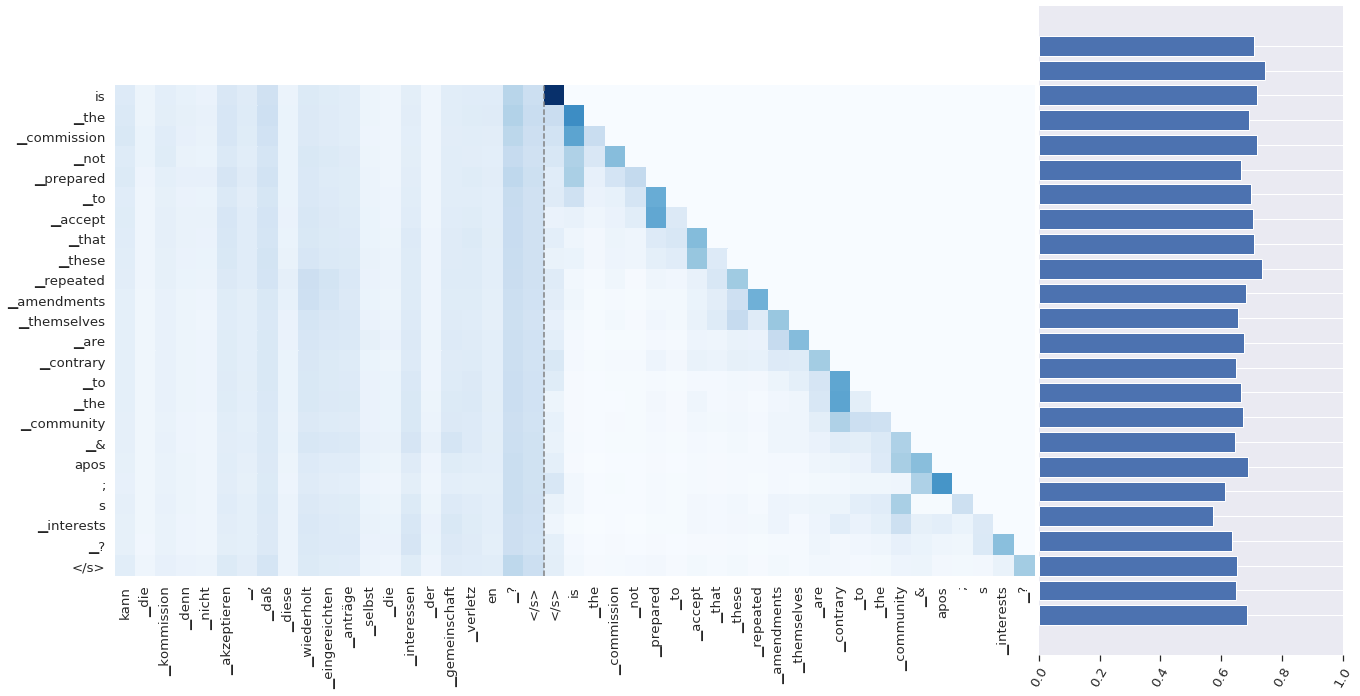

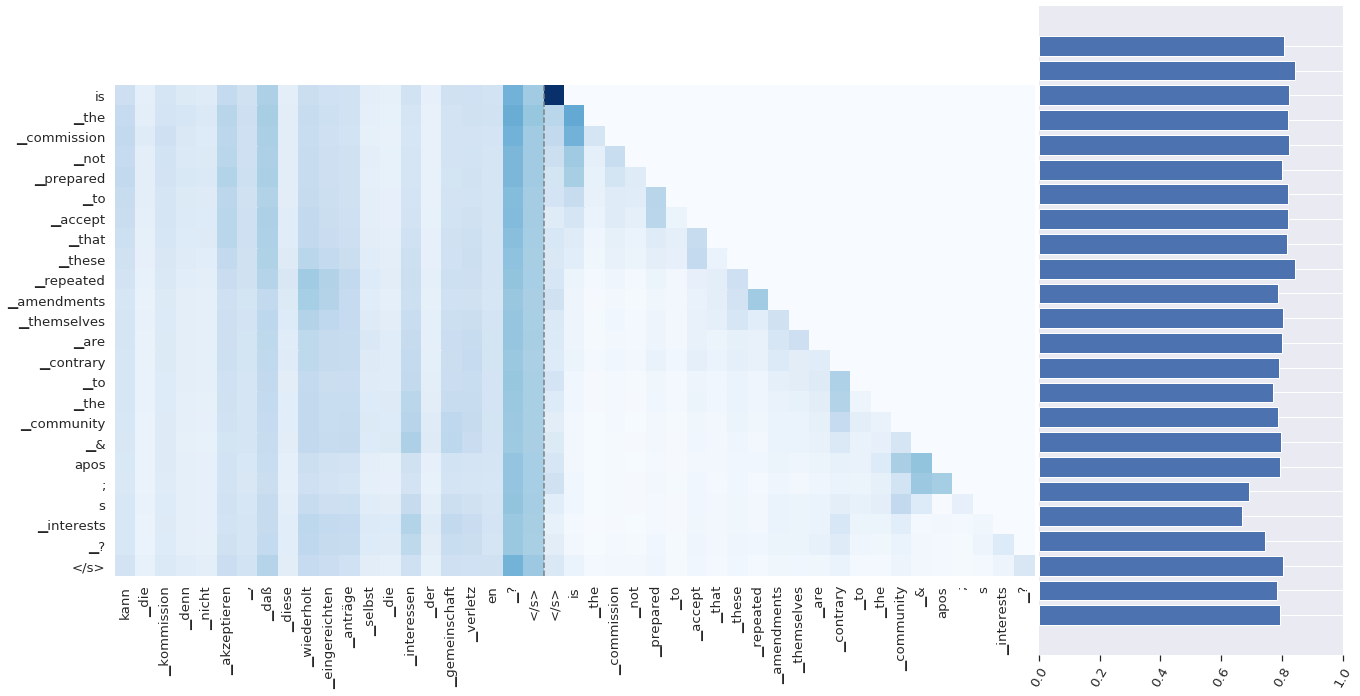

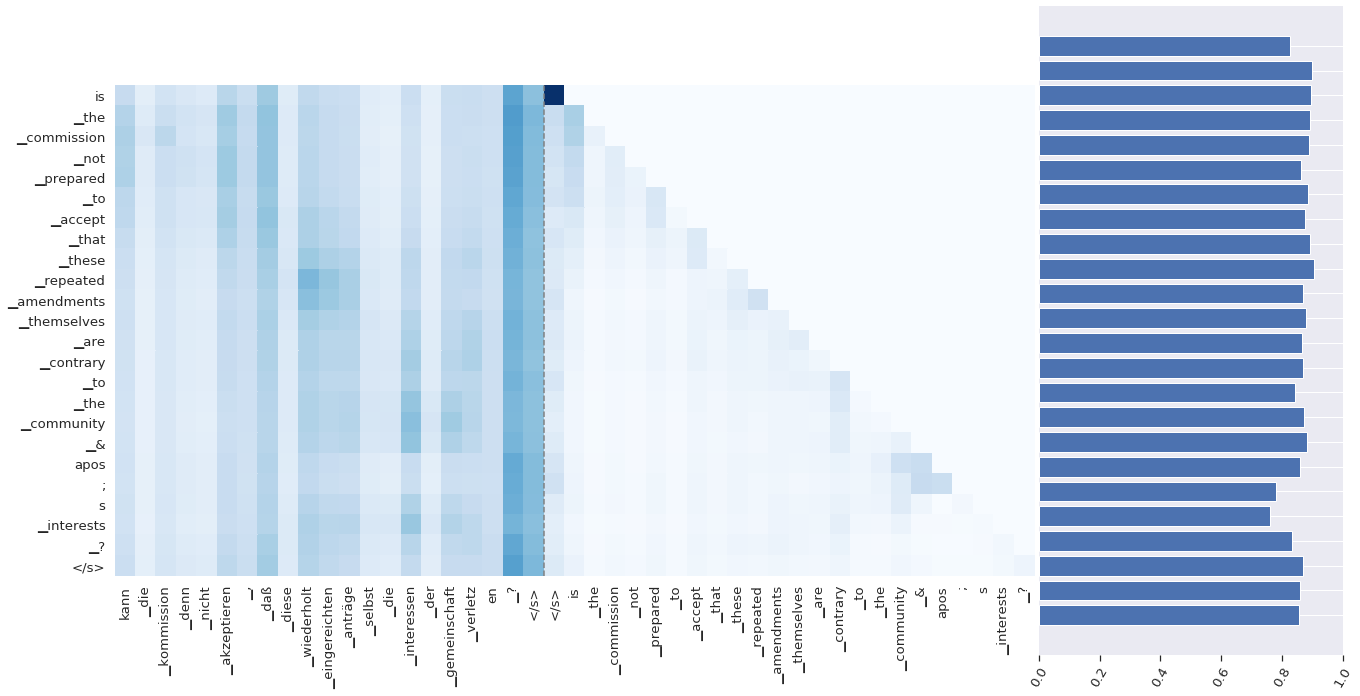

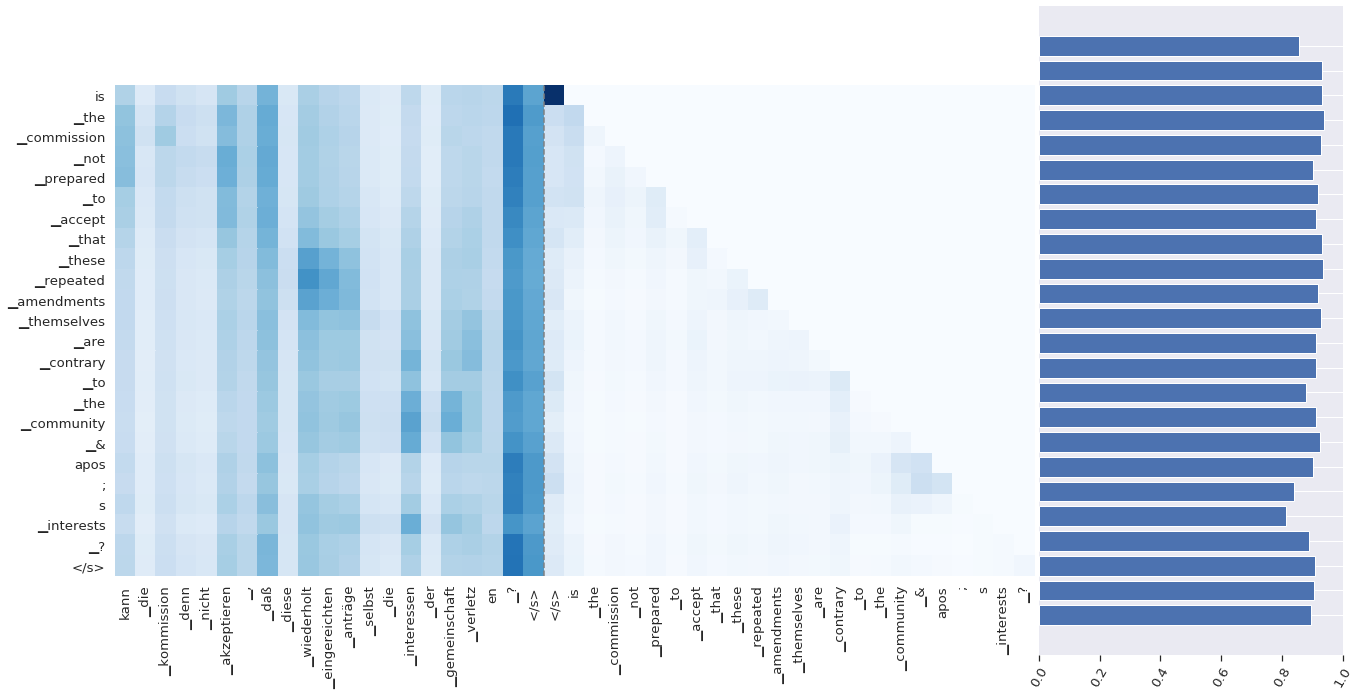

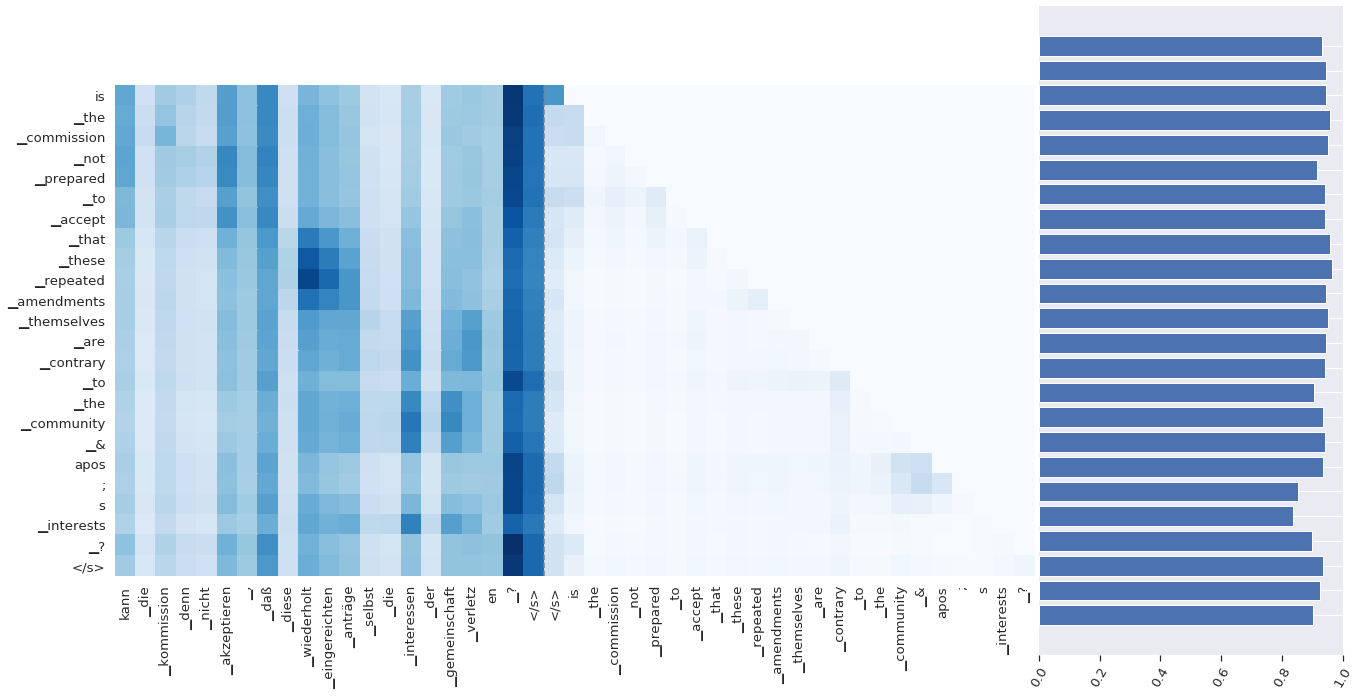

In [34]:
from matplotlib.gridspec import GridSpec

for layer in range(0,NUM_LAYERS):

    fig = plt.figure(figsize=(22, 20))
    gs = GridSpec(5, 4)
    gs.update(wspace=0.015, hspace=0.05)#1.2
    ax_main = plt.subplot(gs[0:5, :3])
    ax_yDist = plt.subplot(gs[1:4, 3])#, sharey=ax_main)
    
    contributions_rollout_layer = total_rollout[layer]
    contributions_alti_layer_np = contributions_rollout_layer.detach().cpu().numpy()
    df = pd.DataFrame(contributions_alti_layer_np, columns = source_sentence + ['</s>'] + ['</s>'] + target_sentence, index = predicted_sentence + ['</s>'])
    sns.set(font_scale=1.2)
    sns.heatmap(df,cmap="Blues",square=True,ax=ax_main,cbar=False)#Reds,center=0
    src_contribution = contributions_alti_layer_np[:,:len(src_tok)+1].sum(-1)
    # print(contributions_alti_layer_np[:,:len(src_tok)+1])
    # print(len(src_tok))
    df_src_contribution = pd.DataFrame(src_contribution, columns = ['src_contribution'], index = predicted_sentence + ['</s>'])
    #sns.set_style("white")
    ax_yDist.barh(range(0,len(predicted_sentence + ['</s>'])), df_src_contribution.src_contribution, align='center')
    
    plt.yticks(ticks = range(0,len(predicted_sentence + ['</s>'])) ,labels = predicted_sentence + ['</s>'],fontsize='14')
    plt.gca().invert_yaxis()
    plt.grid(visible=True)
    ax_yDist.set_xlim(0,1)

    #ax_main.set_title('Layer ' + str(layer+1))
    ax_main.axvline(x = len(source_sentence)+0.98, lw=1.5, linestyle = '--', color = 'grey')# ymin = 0, ymax = 15

    #ax_yDist.set_title('Source contribution')
    ax_yDist.set_yticklabels([])
    #sns.despine(left=True, bottom=True)
    ax_yDist.xaxis.set_ticks_position("bottom")
    plt.xticks(rotation=60)
    ax_yDist.xaxis.grid(False)

    ax_yDist.spines['top'].set_visible(False)
    ax_yDist.spines['right'].set_visible(False)
    ax_yDist.spines['bottom'].set_visible(False)
    ax_yDist.spines['left'].set_visible(False)

    #plt.gcf().subplots_adjust(bottom=0.2)

In [24]:
plt.figure(figsize=(15,6),dpi=200)
df = pd.DataFrame(contributions_alti_layer_np, columns = source_sentence + ['</s>'] + ['</s>'] + target_sentence, index = predicted_sentence + ['</s>'])
sns.set(font_scale=1.25)
s = sns.heatmap(df,cmap="Blues",square=True, cbar=False)
s.set_xlabel('Source sentence | Target prefix', fontsize=17)
s.set_ylabel('$\longleftarrow$ Decoding step', fontsize=17)
plt.axvline(x = len(source_sentence)+0.98, lw=1.5, linestyle = '--', color = 'grey')# ymin = 0, ymax = 15
plt.xticks(rotation=60);


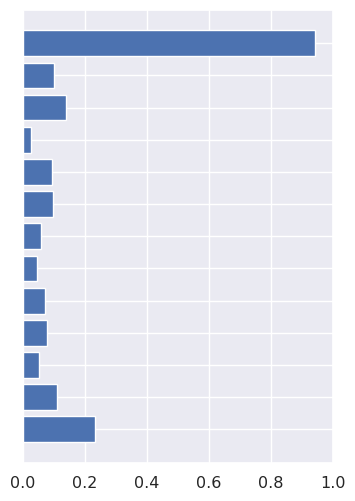

In [116]:
plt.figure(figsize=(4,6),dpi=100)

plt.barh(range(0,len(predicted_sentence + ['</s>'])), df_src_contribution.src_contribution, align='center')
    
plt.yticks(ticks = range(0,len(predicted_sentence + ['</s>'])) ,labels = predicted_sentence + ['</s>'],fontsize='14')
plt.gca().invert_yaxis()
plt.grid(visible=True)
plt.xlim(0,1);

# #ax_main.set_title('Layer ' + str(layer+1))
# ax_main.axvline(x = len(source_sentence)+0.98, lw=1.5, linestyle = '--', color = 'grey')# ymin = 0, ymax = 15

# #ax_yDist.set_title('Source contribution')
locs, labels = plt.yticks()
plt.yticks(locs,[]);
# #sns.despine(left=True, bottom=True)
# ax_yDist.xaxis.set_ticks_position("bottom")
# plt.xticks(rotation=60)
# ax_yDist.xaxis.grid(False)

### Word-word alignments (source-target) from contributions

In [ ]:
contribution_pred_src = contributions_alti_layer_np[:,:len(src_tok)+1]
src_word_to_bpe = align.convert_bpe_word(src_tok_str.split(), src_word_sent.split())
tgt_word_to_bpe = align.convert_bpe_word(tgt_tok_str.split(), tgt_word_sent.split())

#contribution_pred_src = contribution_pred_src[list(range(1,len(contribution_pred_src)))+[0]]

contributions_word_word = align.get_word_word_attention(contribution_pred_src, src_word_to_bpe, tgt_word_to_bpe, remove_EOS=False)
contributions_word_word.shape

In [ ]:
## Soft alignment
plt.figure(figsize=(20,8))
df = pd.DataFrame(contributions_word_word, columns = src_word_sent.split() + ['</s>'], index = tgt_word_sent.split() + ['</s>'])
sns.set(font_scale=1.6)
sns.heatmap(df,cmap="Blues",square=True,cbar=True);

In [ ]:
## Hard alignment
a_argmax = np.argmax(contributions_word_word, -1)
print(a_argmax)
contributions_word_word_hard = np.zeros(contributions_word_word.shape)

for i, j in enumerate(a_argmax):
    contributions_word_word_hard[i][j] = 1

plt.figure(figsize=(20,8))
df = pd.DataFrame(contributions_word_word_hard, columns = src_word_sent.split() + ['</s>'], index = tgt_word_sent.split() + ['</s>'])
sns.set(font_scale=1.6)
sns.heatmap(df,cmap="Blues",square=True,cbar=True);

In [ ]:

# We don't consider alignment of /s (target)
contributions_word_word_hard = contributions_word_word_hard[:-1]
# Assign final mark alignments
contributions_word_word_hard[-1,-2] = 1
plt.figure(figsize=(20,8))
df = pd.DataFrame(contributions_word_word_hard, columns = src_word_sent.split() + ['</s>'], index = tgt_word_sent.split())
sns.set(font_scale=1.6)
sns.heatmap(df,cmap="Blues",square=True,cbar=True);

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
colors = ["whitesmoke", "gainsboro", "lightgrey", "lightgray", "silver",
            "darkgrey", "darkgray", "grey", "gray", "dimgrey", "dimgray", "black"]
cmap = LinearSegmentedColormap.from_list('Custom', colors, len(colors))

gold_alignment = europarl_dir / "gold_alignment/alignment.talp"

i=0
attention_matrix = np.zeros((len(tgt_word_sent.split())+1,len(src_word_sent.split())+1))
with open(gold_alignment, 'r') as f:
    line = f.readlines()[i]
    print(line)
    for alignment_string in line.split():
        t, s = align.parse_single_alignment(alignment_string, reverse=True)
        print(t,s)
        attention_matrix[t-1][s-1] = 1
#attention_matrix = attention_matrix[[len(attention_matrix)-1]+list(range(0,len(attention_matrix)-1))]

plt.figure(figsize=(8,8))
fontsize = 10
rotation = 90
df_gold = pd.DataFrame(attention_matrix, columns=src_word_sent.split()+["</s>"],index=tgt_word_sent.split()+["</s>"])
sns.heatmap(df_gold,cmap=cmap,cbar=False,square=True)
sns.set(font_scale=1)